# NILM disaggregation task

- Goal: Combine dissagregated signals and perform multi-label classification

In [1]:
!conda create -y -n nilmtk python=3.9 pip
!source activate nilmtk && python -m ipykernel install --user --name nilmtk --display-name "Python (nilmtk)"

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.5.2

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /opt/conda/envs/nilmtk

  added / updated specs:
    - pip
    - python=3.9


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    libzlib-1.2.13             |       hd590300_5          60 KB  conda-forge
    pip-23.2                   |     pyhd8ed1ab_0         1.3 MB  conda-forge
    setuptools-68.0.0          |     pyhd8ed1ab_0         453 KB  conda-forge
    wheel-0.40.0               |     pyhd8ed1ab_1          56 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         1.9 MB

The following NEW packages will be INSTALLED:

  _libgcc_mutex      conda-forg

In [2]:
#!rm -r /home/jovyan/.local/share/jupyter/kernels/nilmtk
#!pip uninstall -y -q nilmtk nilm_metadata
!python3 -m pip install pandas numpy networkx scipy tables scikit-learn hmmlearn pyyaml matplotlib xgboost pyts
# Trick to install NILM regardless of its dependencies
!python3 -m pip install --no-deps git+https://github.com/nilmtk/nilmtk@master
!python3 -m pip install --no-deps git+https://github.com/nilmtk/nilm_metadata@master

  Using cached hmmlearn-0.3.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (160 kB)
  Using cached xgboost-1.7.6-py3-none-manylinux2014_x86_64.whl (200.3 MB)
  Using cached pyts-0.13.0-py3-none-any.whl (2.5 MB)
  Using cached scikit_learn-1.3.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.8 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.1.3
    Uninstalling scikit-learn-1.1.3:
      Successfully uninstalled scikit-learn-1.1.3
  Cloning https://github.com/nilmtk/nilmtk (to revision master) to /tmp/pip-req-build-h011f2ld
  Running command git clone --filter=blob:none --quiet https://github.com/nilmtk/nilmtk /tmp/pip-req-build-h011f2ld
  Resolved https://github.com/nilmtk/nilmtk to commit b2c514479cef478cab872cb635056da08d5352a1
  Preparing metadata (setup.py) ... done
  Created wheel for nilmtk: filename=nilmtk-0.4.0.dev1+git.b2c5144-py3-none-any.whl size=279177 sha256=d5d685f85c309a329669c2539d7cc7eb330a7e2bf36cc7

In [3]:
!which python
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from nilmtk import DataSet
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict
from joblib import Memory

from pprint import pprint

from nilmtk import DataSet
import multiprocessing as mp

from typing import Dict

/opt/conda/bin/python


In [5]:
memory = Memory(location='./cache')

In [4]:
#from nilmtk.dataset_converters.refit.convert_refit import convert_refit
#convert_refit('/home/jovyan/datasets/NILM/REFIT/', output_filename='/tmp/refit.hdf5')

#from nilmtk.dataset_converters.ukdale.convert_ukdale import convert_ukdale
#convert_ukdale('/home/jovyan/data/ukdale/', output_filename='ukdale.hdf5')

In [6]:
@memory.cache
def load_refit_dataset():
    try:
        dataset = DataSet('./datasets/NILM/iawe.h5')

        samples = []
        for building_idx, building in dataset.buildings.items():
            for meter in building.elec.all_meters():

                data = list(meter.load())
                assert len(data) == 1

                assert len(meter.appliances) < 2

                # TODO: Poglej s kje jemlje sample Jakob.
                sample = (building_idx, list([a.type['type'] for a in meter.appliances]), data, meter.good_sections())

                samples.append(sample)
                
        return samples

    except Exception as e:
        dataset.store.close()
        raise e
        
dataset = load_refit_dataset()

________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-390927930.load_refit_dataset...
load_refit_dataset()
______________________________________________load_refit_dataset - 11.1s, 0.2min


In [6]:
def data_preparation(dataset):
    X = defaultdict(lambda: [])

    for (idx, appliances, data, good_sections) in dataset:
        if not appliances:
            continue
            
        appliance = appliances[0]
        data = data[0]
    
        samples = [data[good.start:good.end] for good in good_sections]
        X[appliance].extend(samples)
        
    for appliance, samples in X.items():
        print(appliance, len(samples))
        
    return X

prepared_data  = data_preparation(dataset)

fridge 2924
freezer 7470
washer dryer 1372
washing machine 12790
dish washer 9315
computer 6191
television 12041
electric space heater 2893
food processor 2875
toaster 6513
fridge freezer 9713
microwave 11100
kettle 7631
broadband router 1587
audio system 2637
unknown 2851
tumble dryer 4841
dehumidifier 968
breadmaker 475
games console 475
fan 588
appliance 285
pond pump 285


In [7]:
processed_data = {}

for appliance, samples in prepared_data.items():
    processed_samples = []
    for sample in samples:
        sample = sample.resample('7s').ffill(limit=1).fillna(0)
        
        # It should contain at least one sample
        if len(sample) < 2:
            continue
        
        # TODO: Filter < 20W (Poglej Blažev članek
        if not np.any(sample.to_numpy() > 20):
            continue
            
        processed_samples.append(sample)
        
    
    processed_data[appliance] = list(processed_samples)
    
    #processed_data[appliance] = list([s.resample('7s').ffill(limit=1).fillna(0) for s in samples])
    
processed_data.pop('unknown', None);

for k, v in processed_data.items():
    print(k, len(v))

fridge 1598
freezer 4385
washer dryer 316
washing machine 2590
dish washer 1769
computer 2893
television 5355
electric space heater 255
food processor 458
toaster 1659
fridge freezer 5415
microwave 2873
kettle 2348
broadband router 895
audio system 315
tumble dryer 739
dehumidifier 161
breadmaker 98
games console 117
fan 63
appliance 61
pond pump 75


In [8]:
"""
Currently, I'm picking random start of appliance, which is not good idea.

"""


def appliance_augmentator_v1(dataset:Dict[str,list], sample_length:int, n_appliances_per_sample:int, random_state:int=None):
    """
    TODO: implement area of interest: sample_start_idx value should be point, where data is above zero.
    """
    
    rng = np.random.default_rng(seed=random_state)
    
    N = n_appliances_per_sample
    L = sample_length
    

    keys = tuple(dataset.keys())
    
    while True:
        series = np.zeros(L, dtype=np.float64)
        labels = np.zeros((len(keys),L), dtype=np.bool)
        
        # Select N random appliances (no replace; same appliance cannot appear twice in the same sample)
        for appliance_idx in rng.choice(len(keys), size=N, replace=False):
            appliance_name = keys[appliance_idx]
            #print(appliance_name)

            n_available_samples = len(dataset[appliance_name])
            sample_idx = rng.choice(n_available_samples)

            sample_series = dataset[appliance_name][sample_idx]

            # pick random time offset for appliance on a new augmented time series
            t_offset = rng.choice(int(L * 0.50))

            #####
            # The total length of sample time-series
            sample_len = len(sample_series)

            # pick random time offset for appliance's sample start
            sample_start_idx = rng.choice(sample_len)

            # total length of a sample (after applying offset)
            sample_subset_len = min(sample_len - sample_start_idx, L - t_offset)
            assert sample_subset_len >= 0

            #print(appliance_name, sample_subset_len)
            
            
            sample_subset_series = sample_series.iloc[sample_start_idx:sample_start_idx+sample_subset_len].to_numpy().squeeze()


            series[t_offset:t_offset+sample_subset_len] += sample_subset_series
            labels[appliance_idx, t_offset:t_offset+sample_subset_len] = sample_subset_series > 0.0
        
        # There has to be two samples present. Even though we combined two subsets, one or both could be empty.
        # Workaround until area of interest is implemented.
        if not (np.sum([(np.any(label) > 0) for label in labels]) == N):
            continue
            
        yield series, labels, keys


def test_appliance_augmentator(augmentator, *args, **kwargs):
    X, y, labels = next(augmentator(processed_data, *args, **kwargs))

    f, ax = plt.subplots()
    ax.set_title('Augmented time-series')
    ax.plot(X)
    f.show()
    
    
    
    n_appliances = kwargs.get('n_appliances_per_sample', None)
    f, ax = plt.subplots()

    
    print('Number of positive datapoints per appliance')
    for mask, label in zip(y, labels):
        if np.sum(mask) == 0:
            continue
        
        print(f'{label}:\t {np.sum(mask)}')
        

        tmp = X.copy()
        tmp[~mask] = 0
        ax.plot(tmp, linestyle=None, marker='.', label=label, alpha=0.5)
        #ax.plot(np.ma.masked_where(mask, np.full_like(X, idx)), marker='.', label=label)
    

    f.legend(title='markers based on mask')
    f.show()
    
#test_appliance_augmentator(appliance_augmentator_v1, sample_length=128, n_appliances_per_sample=2, random_state=None)

### The concept of TS augmentation v2
Want to combine two time-series samples:
- different offesets (random start)
  - what happens when TS do not have even remotely equal length
- sliding window

Number of positive datapoints per appliance
toaster:	 99
games console:	 21


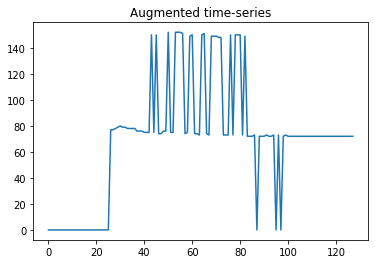

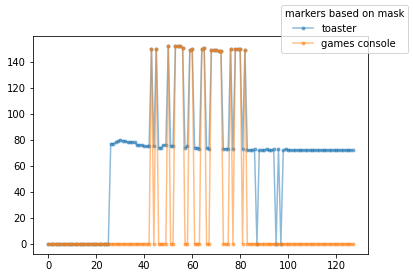

In [9]:
from typing import Iterator, List, Tuple

def appliance_augmentator_v2(dataset:Dict[str,list], sample_length:int, n_appliances_per_sample:int, random_state:int=None) -> Iterator[Tuple[np.ndarray, np.ndarray, List[str]]]:
    
    # Initialize seeded random number generator
    rng = np.random.default_rng(seed=random_state)
    
    # How many appliances are mixed together
    N = n_appliances_per_sample
    
    # Sample length / Window size
    L = sample_length
    
    # Noise floor
    NOISE_FLOOR = 20.0
    
    # Get all available appliances
    appliance_names = tuple(dataset.keys())
    
    # How many appliances are there?
    n_appliances = len(appliance_names)
    
    # Start endless generator of samples
    while True:
        # pre-allocate array for time series
        series = np.zeros(L, dtype=np.float64)
        
        # pre-allocate boolean array for masks
        labels = np.zeros((n_appliances, L), dtype=bool)
        
        # Select N random appliances (no replace, because same appliance should not appear twice in the same sample)
        # TODO: Relax this limitation in the future, for cases where multiple of same appliances are in the same household
        for appliance_idx in rng.choice(n_appliances, size=N, replace=False):
            appliance_name = appliance_names[appliance_idx]

            # Pick random sample of a selected appliance
            n_available_samples = len(dataset[appliance_name])
            sample_idx = rng.choice(n_available_samples)
            
            # retrieve sample as NumPy array with appropriate dimensions
            sample_series = dataset[appliance_name][sample_idx].iloc[:].to_numpy().squeeze(axis=-1)
            
            # If sample is too short (shorter than L), give padding on both sides.
            if len(sample_series) <= L:
                padding = L // 2
                sample_series = np.pad(sample_series, (padding, padding), mode='constant', constant_values=0)
            
            
            # The total length of sample time-series
            sample_len = len(sample_series)
            
            # Sanity check(s)
            assert sample_len >= L, f'Sample length should be equal or larger than L: {sample_len} >= {L}'
            
            sample_offset = rng.choice(sample_len - L)
            
            sample = sample_series[sample_offset:sample_offset+L]
            
            # TODO: Currently, we ignore device in idle state (x =< NOISE_FLOOR)
            mask = sample > NOISE_FLOOR  # find samples that are above noise floor
            
            series[:] += sample
            labels[appliance_idx, :] |= mask  # logical ORing the mask
            
        # Add random (constant) offset
        #series += rng.random() * (NOISE_FLOOR)
            
        # There has to be two samples present. Even though we combined two subsets, one or both could be empty.
        # Workaround until area of interest is implemented.
        if not (np.sum([(np.any(label) > 0) for label in labels]) == N):
            continue
            
        yield series, labels, appliance_names
        

test_appliance_augmentator(appliance_augmentator_v2, sample_length=128, n_appliances_per_sample=2, random_state=43)

In [10]:
X, Y, labels = [], [], None
generator = appliance_augmentator_v2(processed_data, sample_length=128, n_appliances_per_sample=2, random_state=0xDEADBEEF)
for idx, (_x, _y, labels) in zip(range(100_000), generator):
    X.append(_x), Y.append(_y)
    
X, Y = np.asarray(X), np.asarray(Y)
print(X.shape, Y.shape)

y = np.any(Y, axis=-1) > 0
sample_weight = np.sum(Y, axis=-1) / 128
print(X.shape, y.shape)

(100000, 128) (100000, 22, 128)
(100000, 128) (100000, 22)


In [11]:
!pip install -q scikit-learn-intelex
from sklearnex import patch_sklearn
patch_sklearn()

from sklearn import pipeline, metrics, linear_model, model_selection, multioutput, tree, ensemble, neural_network
import xgboost as xgb

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [12]:
pipe = multioutput.MultiOutputClassifier(
    #tree.DecisionTreeClassifier(min_samples_leaf=30, random_state=42),
    #linear_model.LogisticRegressionCV(cv=10, scoring='f1', max_iter=10_000, n_jobs=-1, random_state=42),
    #xgb.XGBClassifier(n_jobs=-1, random_state=42)
    #ensemble.RandomForestClassifier(criterion='entropy', max_features='sqrt', min_samples_leaf=30, max_depth=64, n_jobs=-1, random_state=42, class_weight='balanced'),
    ensemble.RandomForestClassifier(min_samples_leaf=30, max_depth=64, n_jobs=-1, random_state=42, class_weight='balanced'),
    #neural_network.MLPRegressor(hidden_layer_sizes=(100, 100, 100), random_state=42, early_stopping=True),
    n_jobs=-1,
)

cv = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
y_pred = model_selection.cross_val_predict(pipe, X, y, cv=cv, n_jobs=-1)

In [13]:
print(metrics.classification_report(y, y_pred, target_names=labels, zero_division=0))

                       precision    recall  f1-score   support

               fridge       0.22      0.75      0.34     10764
              freezer       0.26      0.74      0.38     14820
         washer dryer       0.05      0.82      0.10      1423
      washing machine       0.12      0.82      0.21      5787
          dish washer       0.18      0.66      0.28      5459
             computer       0.27      0.75      0.40     11617
           television       0.21      0.71      0.32     12907
electric space heater       0.32      0.94      0.48      5739
       food processor       0.31      0.87      0.46     13611
              toaster       0.22      0.80      0.34      8714
       fridge freezer       0.29      0.80      0.43     15169
            microwave       0.18      0.78      0.29      6973
               kettle       0.14      0.90      0.24      2771
     broadband router       0.49      0.87      0.63     14966
         audio system       0.09      0.87      0.17  

# Generate dataset for further analysis

## time series to image transformation and deep learning

In [25]:
#!pip uninstall pillow -y
!pip install -U -q pip
#!mamba uninstall -qy pytorch torchvision torchaudio libgcc
!mamba install -q -y pytorch=1.12 torchvision torchaudio torchmetrics cudatoolkit=11.6 -c pytorch
#!jupyter nbextension enable --py widgetsnbextension 
#!mamba install -q -y libgcc
!pip install -q -U pillow

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
#import torchvision.transforms as T
#from torchvision import transforms as T
from torchvision.models import resnet18, vgg11_bn

torch.Size([128, 3, 224, 224])


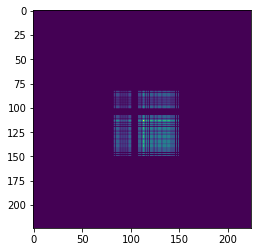

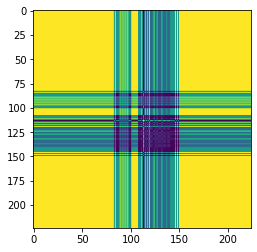

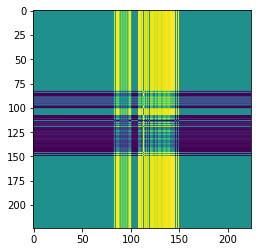

In [75]:
from pyts.image import GramianAngularField

class NILMDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, transform=None):
        super().__init__()
        self.data, self.labels, self.transform = data, labels, transform
        
    def __getitem__(self, idx):
        inputs:np.ndarray = self.data[idx]
        labels = self.labels[idx]
        
        inputs = inputs.astype(np.float64)
        
        inputs = np.expand_dims(inputs, axis=0)
        #inputs = np.matmul(inputs.T, inputs)
        
        # Normalize
        #inputs /= inputs.nelements()
        gram = np.matmul(inputs.T, inputs)
        gram /= gram.nelements()
        
        gasf = GramianAngularField(method='summation').fit_transform(inputs)
        gadf = GramianAngularField(method='difference').fit_transform(inputs)
        
        inputs = np.concatenate([gram, gasf, gadf], axis=0)
        
        #inputs = np.expand_dims(inputs, axis=0)
        #print(inputs.shape)
        
        labels = np.any(labels, axis=-1) > 0
        
        if self.transform:
            return self.transform(inputs), labels
        
        #inputs = np.expand_dims(inputs, axis=0)

        return inputs, labels
    
    def __len__(self):
        return len(self.data)

class NILMIterableDataset(torch.utils.data.IterableDataset):
    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        #print(worker_info)
        random_state = worker_info.seed
        generator = appliance_augmentator_v2(processed_data, sample_length=224, n_appliances_per_sample=3, random_state=random_state)
        
        for inputs, labels, _ in generator:
            inputs = np.expand_dims(inputs, axis=0)
            #inputs = np.matmul(inputs.T, inputs)
            #inputs = np.expand_dims(inputs, axis=0)
            
            gram = np.matmul(inputs.T, inputs)
            gram = np.expand_dims(gram, axis=0)
            gram /= gram.size

            #print(gram.shape)
            gasf = GramianAngularField(method='summation').fit_transform(inputs)
            gadf = GramianAngularField(method='difference').fit_transform(inputs)
            #print(gasf.shape)
            #print(gadf.shape)
            
            
            inputs = np.concatenate([gram, gasf, gadf], axis=0)

            labels = np.any(labels, axis=-1) > 0

            yield inputs, labels
    

def worker_init_fn(worker_id):                                                                                                                                
    seed = 42 + worker_id              
                                                                                                                                   
    torch.manual_seed(seed)                                                                                                                                   
    torch.cuda.manual_seed(seed)                                                                                                                              
    torch.cuda.manual_seed_all(seed)                                                                                          
    np.random.seed(seed)                                                                                                             
    #random.seed(seed)                                                                                                       
    #torch.manual_seed(seed)                                                                                                                                   
    return
    
torch.manual_seed(42)
    

#trainset = NILMDataset(X, Y)
trainset = NILMIterableDataset()

trainloader = DataLoader(trainset, batch_size=128, num_workers=32, pin_memory=True, persistent_workers=False)

#print(trainset[0][0].shape, trainset[0][1].shape)
for inputs, labels in trainloader:
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    print(inputs.shape)
    plt.imshow(inputs[0][0])
    plt.show()
    plt.imshow(inputs[0][1])
    plt.show()
    plt.imshow(inputs[0][2])
    plt.show()
    break
    

In [76]:
from torchmetrics import Accuracy

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, padding=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=5, padding=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, padding=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5, padding=3, stride=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        
        self.linear = nn.Sequential(
            nn.Linear(64, 22),
        )
        
    def forward(self, x):
        #x = self.gram_matrix(x, normalize=False)
        #x = self.bw2rgb(x)
        x = self.nn(x)
        x = torch.squeeze(x)
        x = self.linear(x)
        return x
    
    
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = vgg11_bn()
        #self.bw2rgb = nn.Conv2d(1, 3, kernel_size=1)
        
    def forward(self, x):
        #x = self.gram_matrix(x, normalize=False)
        #x = self.bw2rgb(x)
        x = self.nn(x)
        #x = torch.squeeze(x)
        #x = self.linear(x)
        return x
    
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-5)
criterion = nn.BCEWithLogitsLoss().to(device)

cuda


In [ ]:
from tqdm import tqdm

net = net.float()
net.train()

EPOCHS = 32
idx = 1

running_loss = []

pbar = tqdm(trainloader, unit='batches')



running_accuracy = []
running_loss = []

for (inputs, labels) in pbar:

    if idx and idx % 1000 == 0:
        print(f'loss = {sum(running_loss) / len(running_loss):.4f}')

        accuracy = metrics.accuracy_score(np.concatenate(y_test), np.concatenate(y_pred))
        print(f'accuracy: {accuracy:.4f}')

        running_loss = []
        #pbar = tqdm(trainloader)
        y_pred = []
        y_test = []


    inputs = inputs.float().to(device)
    labels = labels.float().to(device)

    labels = F.pad(labels, pad=(0, 1000 - 22, 0, 0))
    #print(inputs.shape, labels.shape)

    optimizer.zero_grad()

    outputs = net(inputs.float())
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    running_loss.append(loss.item())
    #predict = np.round(torch.sigmoid(outputs).cpu().detach().numpy())

    #y_pred.append(predict)
    #y_test.append(labels.cpu().detach())
    
    accuracy = metrics.accuracy_score(
        labels.cpu().detach(),
        np.round(torch.sigmoid(outputs).cpu().detach().numpy())
    )
    
    running_loss.append(loss.item())
    running_accuracy.append(accuracy)
    
    if len(running_loss) > 100:
        running_loss = running_loss[-100:]
        
    if len(running_accuracy) > 100:
        running_accuracy = running_accuracy[-100:]
    
    pbar.set_postfix_str(
        f'avg_loss={sum(running_loss) / len(running_loss):.8f}, '
        f'avg_acc={sum(running_accuracy) / len(running_accuracy):.8f}, '
        f'loss={loss.item():.8f}, '
        f'acc={accuracy:.8f}'
    )
        

    
    
print('Finished Training') 
    

8638batches [27:28,  5.32batches/s, avg_loss=0.00666827, avg_acc=0.00304688, loss=0.00664192, acc=0.00000000]

In [ ]:
# Test
target = torch.as_tensor([1, 0, 1]).float()

output = torch.as_tensor([100, 0, 100]).float()

criterion = torch.nn.BCEWithLogitsLoss()
criterion(output, target)